# Introduction



Libraries used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Loading and Treating Dataset

### Description
This study uses the patent dataset provided by Emer (Emer,2025), available in https://zenodo.org/records/15545361. The dataset was selected because it comprises approximately 63,000 United States patents related to climate-oriented Artificial Intelligence (AI) technologies. It was constructed using data from the PatentsView database of the United States Patent and Trademark Office (USPTO), filtered according to the Cooperative Patent Classification (CPC) system. Specifically, CPC classes Y02 and Y04S were used to identify environmentally relevant technologies, while the Artificial Intelligence Patent Dataset (AIPD) was used to identify AI-related inventions.

The resulting dataset contains patent abstracts spanning the period from 1976 to 2023. After filtering, a topic modeling procedure based on the BERTopic framework was applied to cluster patents into sixteen distinct technology domains. In addition, a column denoted real-value was incorporated, representing a market-implied private economic value proxy derived from the methodology proposed by (Kogan,2017).

### Loading dataset

In [2]:
root_path = '../dataset/'
path_1 = f'{root_path}Green_AI_Patents.csv'

df_green_AI = pd.read_csv(path_1)

### Checking dataset

In [3]:
df_green_AI.dtypes

patent_id              int64
cpc_subclass          object
patent_date           object
patent_title          object
assignee              object
country               object
forward_citations      int64
tech_domain          float64
real_value           float64
dtype: object

Preparing dataset

In [4]:
# columns used
id_col='patent_id'
year_col = 'year'
domain_id_col = 'tech_domain'
pat_date_col = 'patent_date'
forward_citation_col = 'forward_citations'
real_value_col = 'real_value'

Following the reference table provided by authors, below are the corresponding names of each domain:

In [5]:
domain_labels = {
	0:"Data Processing & Memory Management",
	1:"Microgrid & Distributed Energy Systems",
	2:"Vehicle Control & Autonomous Powertrains",
	3:"Irrigation & Agricultural Water Mgmt",
	4:"Photovoltaic & Electrochemical Devices",
	5:"Clinical Microbiome & Therapeutics",
	6:"Combustion Engine Control",
	7:"Battery Charging & Management",
	8:"HVAC & Thermal Regulation",
	9:"Lighting & Illumination Systems",
	10:"Exhaust & Emission Treatment",
	11:"Wind Turbine & Rotor Control",
	12:"Aircraft Wing Aerodynamics & Control",
	13:"Meteorological Radar & Weather Forecasting",
	14:"Fuel Cell Systems & Electrodes",
	15:"Turbine Airfoils & Cooling"
}


### Removing null values

In [6]:
# Checking for null values
df_green_AI.isna().sum()

patent_id                0
cpc_subclass             0
patent_date              0
patent_title             0
assignee              3847
country               4171
forward_citations        0
tech_domain            989
real_value           37020
dtype: int64

In [7]:
df_green_AI = df_green_AI.dropna(subset=[domain_id_col])

### Removing outliers

In [8]:
# Removing outliers detected by BERTopic
df_green_AI = df_green_AI[df_green_AI[domain_id_col]!=-1]

### Formating columns

In [9]:
df_green_AI[id_col] = df_green_AI[id_col].astype(str)
df_green_AI[year_col] = pd.to_datetime(df_green_AI[pat_date_col]).dt.year
df_green_AI[domain_id_col] = df_green_AI[domain_id_col].astype(int)

### Removing duplicates

In [10]:
df_green_AI.duplicated().sum()

np.int64(0)

Sorting domain to alphabetic order

In [11]:
domains = sorted(df_green_AI[domain_id_col].unique())
domains_sorted = sorted(domain_labels.keys(), key=lambda d: domain_labels[d])

# Methodology

## Mapping Maturity

Defining the three descriptors with smoothed curves based on Slocum (2001) recommendations

In [12]:
def smooth(series):
    return series.rolling(3, min_periods=1).mean()

Descriptor A: Patent Activity

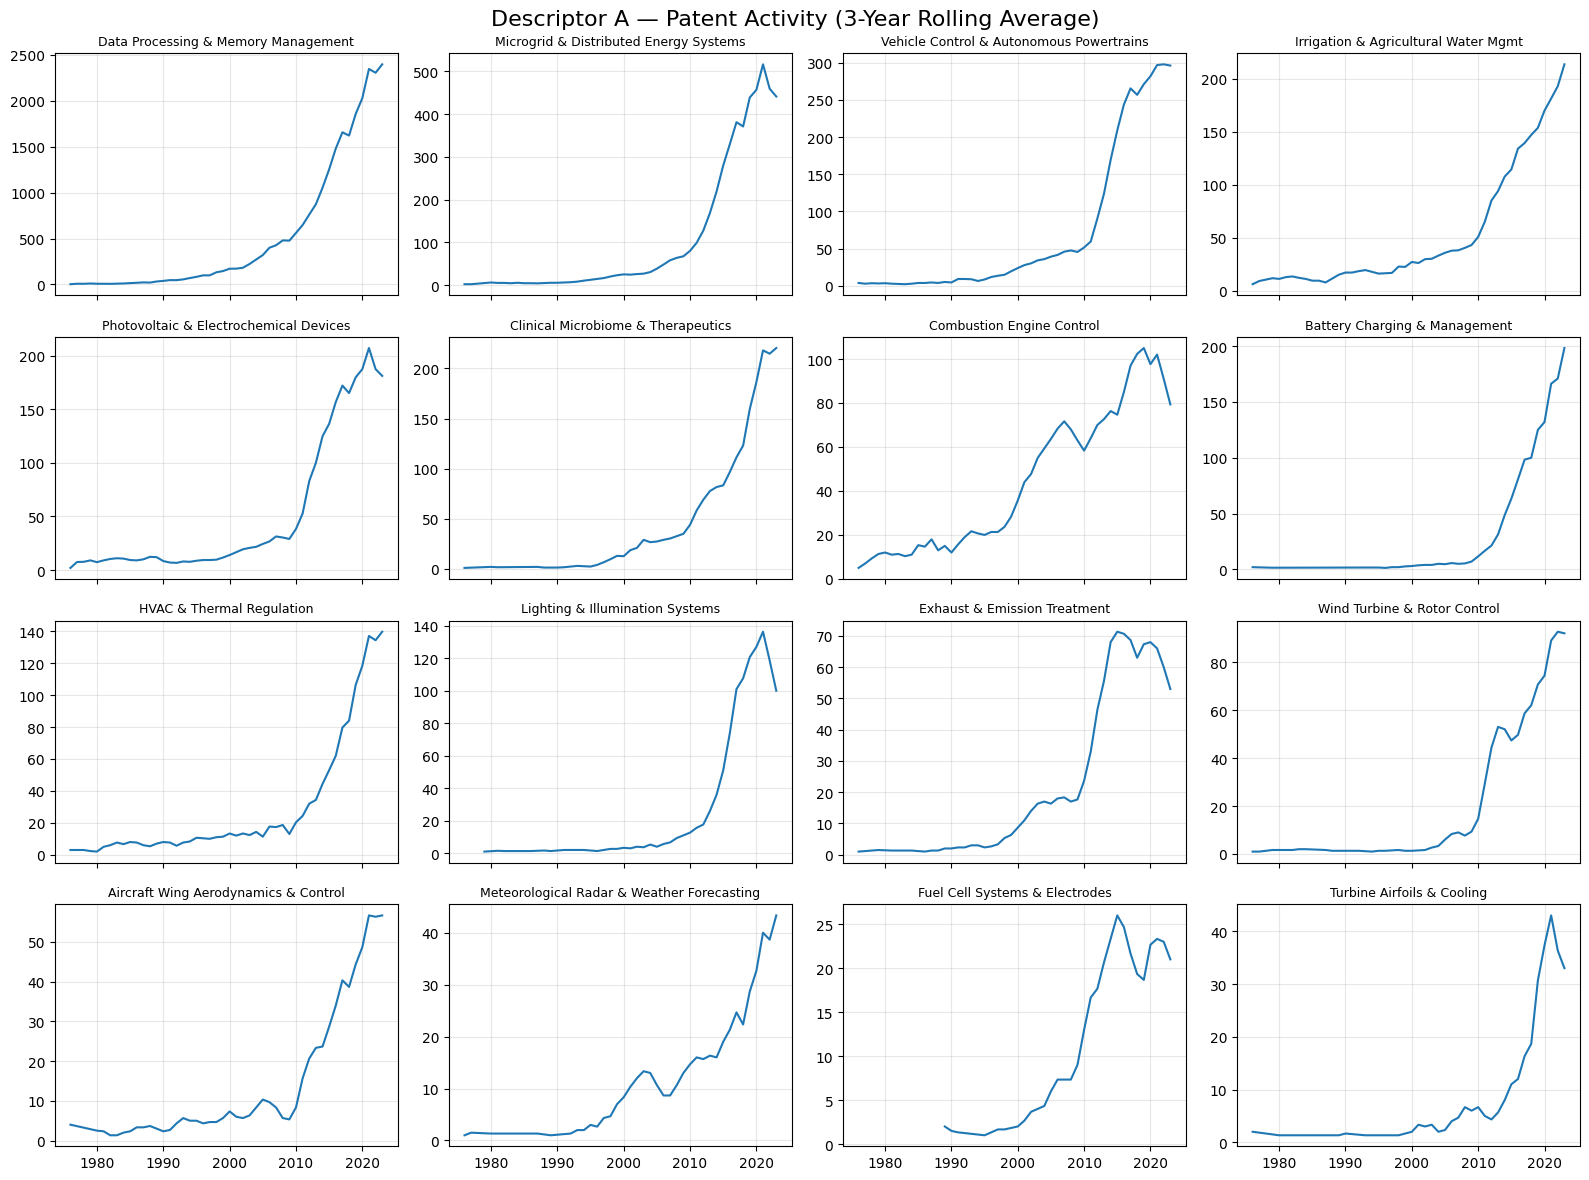

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for ax, d in zip(axes, domains):
    sub = df_green_AI[df_green_AI[domain_id_col]==d]
    A = smooth(sub.groupby(year_col).size())

    ax.plot(A.index, A.values)
    ax.set_title(domain_labels.get(d, f"Domain {d}"), fontsize=9)
    ax.grid(alpha=0.3)

fig.suptitle("Descriptor A — Patent Activity (3-Year Rolling Average)", fontsize=16)
plt.tight_layout()
plt.show()

Descriptor B: Innovation Level proxied by Forward Citations

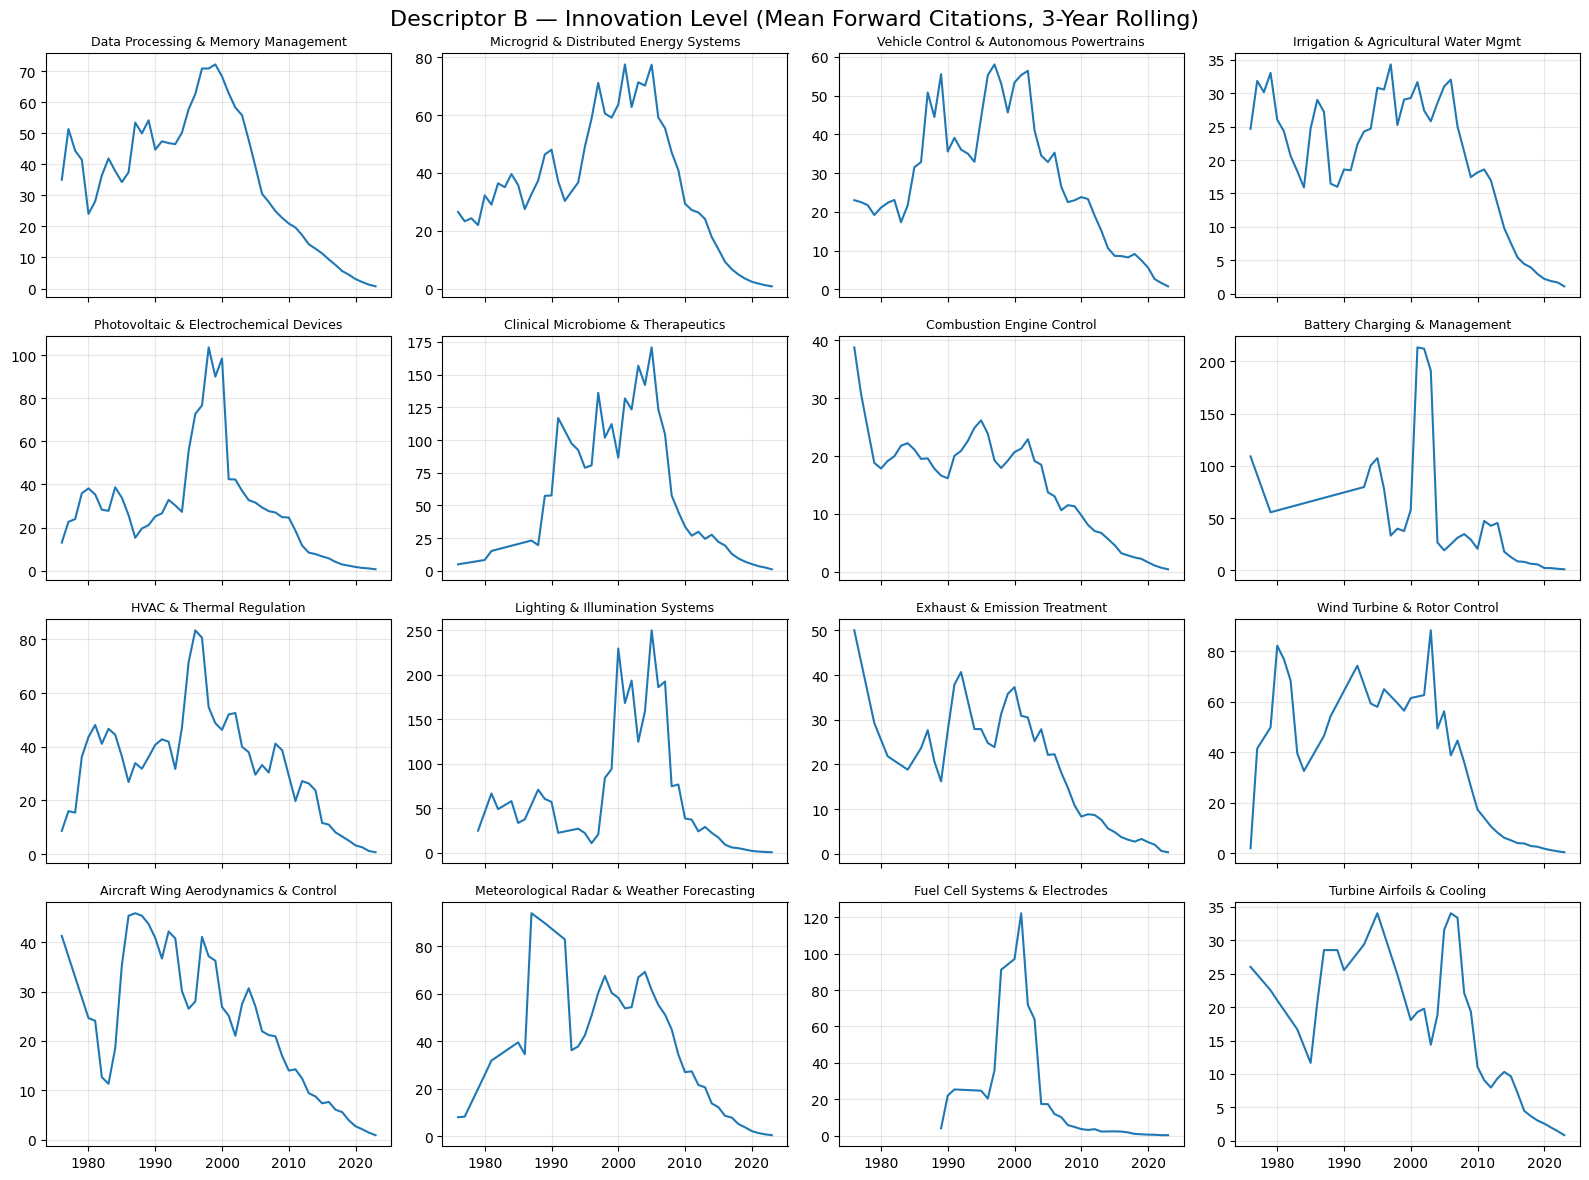

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for ax, d in zip(axes, domains):
    sub = df_green_AI[df_green_AI["tech_domain"]==d]
    B = smooth(sub.groupby(year_col)[forward_citation_col].mean())

    ax.plot(B.index, B.values)
    ax.set_title(domain_labels.get(d, f"Domain {d}"), fontsize=9)
    ax.grid(alpha=0.3)

fig.suptitle("Descriptor B — Innovation Level (Mean Forward Citations, 3-Year Rolling)", fontsize=16)
plt.tight_layout()
plt.show()


Descriptor C: Technical Performance proxied by Kogan market value 

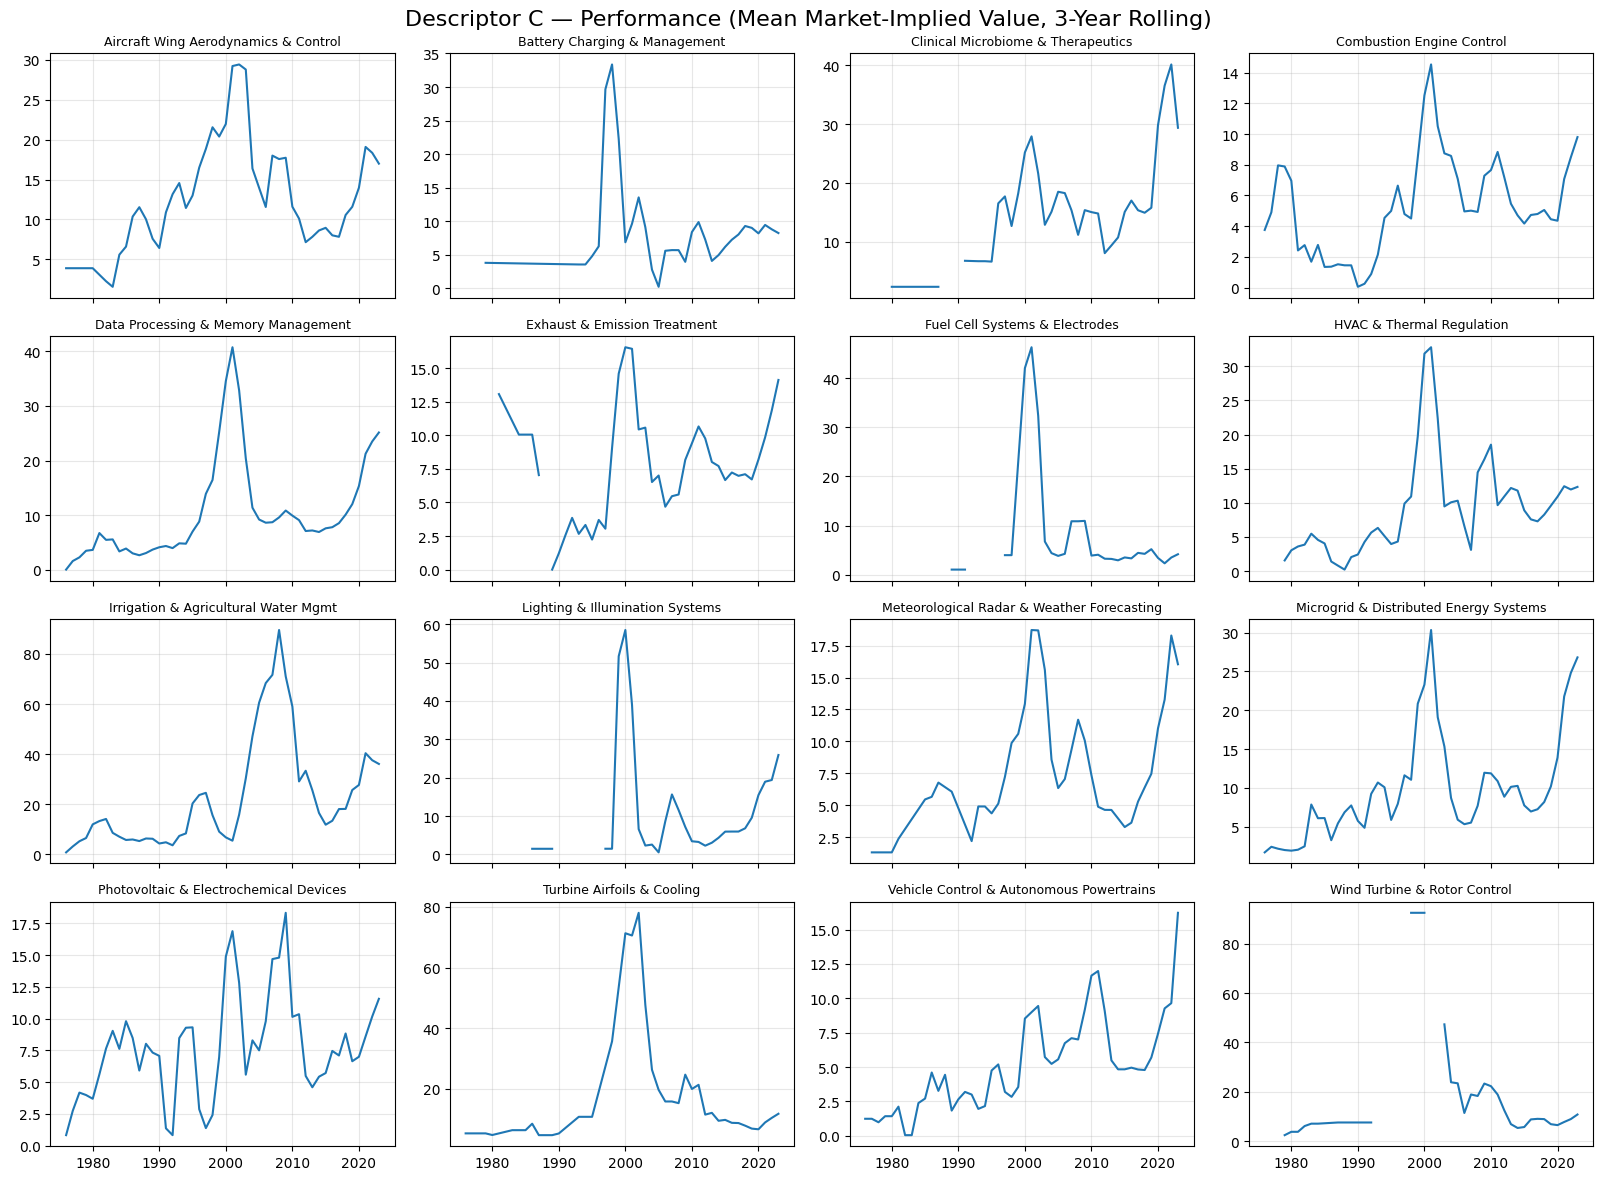

In [15]:
# Descriptor C — Performance (Market Value)
fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for ax, d in zip(axes, domains_sorted):
    sub = df_green_AI[df_green_AI[domain_id_col]==d]
    C = smooth(sub.groupby(year_col)[real_value_col].mean())

    ax.plot(C.index, C.values)
    ax.set_title(domain_labels.get(d, f"Domain {d}"), fontsize=9)
    ax.grid(alpha=0.3)

fig.suptitle("Descriptor C — Performance (Mean Market-Implied Value, 3-Year Rolling)", fontsize=16)
plt.tight_layout()
plt.show()



| Domain                                     | Patent Activity           | Confidence              |  Innovation      |Confidence | Performance              | Maturity           |
| ------------------------------------------ | ------------------------- | ----------------------- | ---------------- |-----------|------------------------- |--------------------|
| Aircraft Wing Aerodynamics & Control       | Growth                    | Medium - Early Maturity |  Exhaustion      |  High     | Episodic value           | Maturity           |
| Battery Charging & Management              | Growth                    | High                    |  Peak Period     |  High     | Stabilization            | Growth             |
| Clinical Microbiome & Therapeutics         | Growth                    | Medium - Early Maturity |  Cooling-off     |  High     | Value Breakthrough Wave  | Growth             |
| Combustion Engine Control                  | Decline                   | High                    |  Exhaustion      |  High     | Episodic value           | Decline            |
| Data Processing & Memory Management        | Growth                    | High                    |  Exhaustion      |  High     | Value Breakthrough Wave  | Maturity           |
| Exhaust & Emission Treatment               | Decline                   | High                    |  Exhaustion      |  High     | Volatile                 | Decline            |
| Fuel Cell Systems & Electrodes             | Infancy                   | High                    |  Unstable Novelty|  High     | Value Breakthrough Spike | Infancy            |
| HVAC & Thermal Regulation                  | Growth                    | High                    |  Stabilization   |Medium-High| Value Breakthrough Wave  | Maturity           |
| Irrigation & Agricultural Water Mgmt       | Growth                    | High                    |  Stabilization   |  High     | Value Breakthrough Wave  | Maturity           |
| Lighting & Illumination Systems            | Decline                   | Medium - Growth         |  Cooling-off     |  High     | Value Breakthrough Spike | Growth             |
| Meteorological Radar & Weather Forecasting | Growth                    | High                    |  Cooling-off     |Medium-High| Volatile                 | Growth             |
| Microgrid & Distributed Energy Systems     | Decline                   | Medium - Growth         |  Cooling-off     |  High     | Emerging Value Uptake    | Growth             |
| Photovoltaic & Electrochemical Devices     | Maturity                  | Medium - Decline        |  Exhaustion      |  High     | Episodic value           | Maturity           |
| Turbine Airfoils & Cooling                 | Decline                   | High                    |  Stabilization   | Medium    | Major Value Breakthrough | Decline            |
| Vehicle Control & Autonomous Powertrains   | Growth                    | Medium - Maturity       |  Cooling-off     |Medium-High| Emerging Value Uptake    | Growth             |
| Wind Turbine & Rotor Control               | Growth                    | High                    |  Cooling-off     |Medium-High| Value Breakthrough Spike | Maturity           |


## Computing Innovation Pace

Mapping maturity classification to each domain

In [16]:
maturity = {
	12:"Maturity",       
	7:"Growth",       
	5:"Growth",
	6:"Decline",
	0:"Maturity",
	10:"Decline",
	14:"Infancy",
	8:"Maturity",
	3:"Maturity",
	9:"Growth",
	13:"Growth",
	1:"Growth",
	4:"Maturity",
	15:"Decline",
	2:"Growth",
	11:"Maturity",
}

In [17]:
# Smoothing window
ROLLING = 3  

Computing knowledge stock log-growth

In [18]:
def compute_log_growth(series, window):
    K = series.cumsum()
    K_s = K.rolling(window=window, min_periods=min(2, window)).mean()
    return np.log(K_s).diff().dropna().mean()

Computing knowledge log-growth doubling time 

In [19]:
def compute_doubling_time(g_rate):
	if g_rate <= 0:
		doubling_time = np.inf
	else:
		doubling_time = np.log(2) / g_rate

	return doubling_time

Computing innovation acceleration

In [20]:
def compute_acceleration(yearly_counts, window=3):
    # cumulative knowledge stock
    K = yearly_counts.cumsum()

    # smooth to remove noise
    K_s = K.rolling(window=window, min_periods=min(2, window)).mean()

    # log-transform (avoid log(0))
    logK = np.log(K_s.replace(0, np.nan))

    # first derivative: pace
    pace = logK.diff()

    # second derivative: acceleration
    accel = pace.diff()

    # return average acceleration (structural signal)
    return accel.dropna().mean()

Computing all year rates

In [21]:
def compute_year_rates(df_green_AI):
	records = []

	for domain, g in df_green_AI.groupby(domain_id_col):
		yearly = g.groupby(year_col).size().sort_index()

		if len(yearly) < 5:
			continue

		g_rate = compute_log_growth(yearly, ROLLING)
		doubling_time = compute_doubling_time(g_rate)
		a = compute_acceleration(yearly, window=ROLLING)

		records.append({
			"tech_domain": domain,
			"growth_rate": g_rate,
			"doubling_time_years": doubling_time,
			"acceleration": a
		})

	year_rates = pd.DataFrame(records)
	return year_rates

In [22]:
d_df = compute_year_rates(df_green_AI)

Classifying each rate

In [23]:
def classify_doubling_time(dt):
    if dt <= 10:
        return "Fast (climate-aligned)"
    elif dt <= 15:
        return "Marginal"
    elif dt <= 25:
        return "Slow"
    else:
        return "Insufficient"
    
def classify_acceleration(a, eps=1e-3):
	if a > eps:
		return "Accelerating"
	elif a < -eps:
		return "Decelerating"
	else:
		return "Stable"
	

In [24]:
d_df["pace_class"] = d_df["doubling_time_years"].apply(classify_doubling_time)
d_df["decel_class"] = d_df["acceleration"].apply(classify_acceleration)
d_df = d_df.sort_values("doubling_time_years")

Adding labels

In [25]:
d_df["maturity_class"] = d_df[domain_id_col].map(maturity)
d_df["domain"] = d_df[domain_id_col].map(domain_labels)

Styling plot

In [30]:
maturity_colors = {
    "Infancy": "#9ecae1", 
    "Growth": "#4bb86a",  
    "Maturity": "#f4c430",
    "Decline": "#d55c4b" 
}


decel_markers = {
    "Accelerating": "▲",
    "Stable": "●",
    "Decelerating": "▼"
}

Ploting results

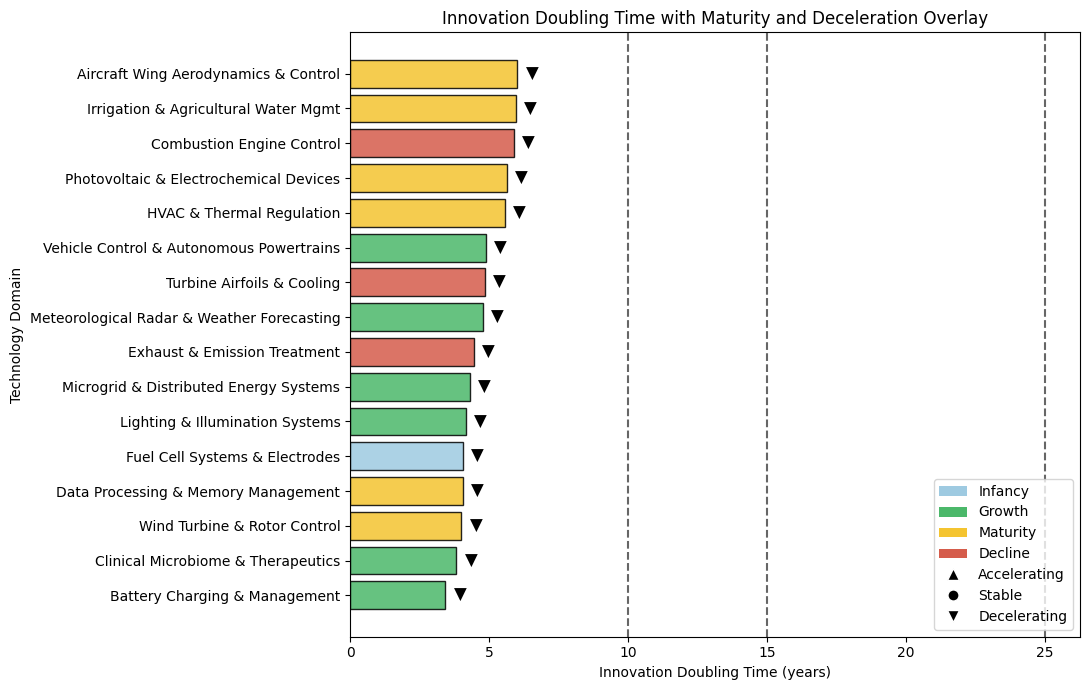

In [31]:
fig, ax = plt.subplots(figsize=(11, 7))

# Doubling Time 
bars = ax.barh(
    d_df["domain"],
    d_df["doubling_time_years"],
    color=d_df["maturity_class"].map(maturity_colors),
    edgecolor="black",
    alpha=0.85
)

# Climate horizons
for h in [10, 15, 25]:
    ax.axvline(h, linestyle="--", color="black", alpha=0.6)

# Overlay deceleration markers
for i, row in enumerate(d_df.itertuples()):
    ax.text(
        row.doubling_time_years + 0.3,
        i,
        decel_markers[row.decel_class],
        va="center",
        ha="left",
        fontsize=12
    )

# Labels
ax.set_xlabel("Innovation Doubling Time (years)")
ax.set_ylabel("Technology Domain")
ax.set_title("Innovation Doubling Time with Maturity and Deceleration Overlay")

# Legends
maturity_legend = [
    Patch(facecolor=c, label=k) for k, c in maturity_colors.items()
]

decel_legend = [
    Line2D([0], [0], marker="^", color="w", label="Accelerating", markerfacecolor="black", markersize=8),
    Line2D([0], [0], marker="o", color="w", label="Stable", markerfacecolor="black", markersize=8),
    Line2D([0], [0], marker="v", color="w", label="Decelerating", markerfacecolor="black", markersize=8)
]

ax.legend(
    handles=maturity_legend + decel_legend,
    loc="lower right",
    frameon=True
)

plt.tight_layout()
plt.show()
